# Introduction
This tutorial builds on the [Spatial Regression tutorial](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html) presented in the [Spatial Data Science for Sustainable Development](https://sustainability-gis.readthedocs.io/en/latest/lessons/L1/intro-to-python-geostack.html) short course, offered at Aalto University, by Henrikki Tenkanen. A basic understanding of spatial econometrics is introduced by way of a statistical framework that effects regression analysis with space. Just as there are several techniques to regress multivariate data, so their are several techniques where spatial ecometrics introduce space in regression analysis. Yet these have no counterpart in multivariate analysis—foregrounding hence their pertinance. Tenkanen discuss several spatial econometric methods. His is a discussion I cannot improve on. Hence, while the same methodology as in the said tutorial is adopted, I suggest following this tutorial alongside his. 

The data consists of thematic and geographic point data of a survey of business signs along Kloof Street, Gardens, and the main arterial in Seapoint, Cape Town. A total of 192 signs for Gardens, and 528 signs for Seapoint were surveyed—the largest signs in terms of Area are that of international firms for example McDonalds and H&M (see part 1 of the tutorial series). It is assumed that apart from a larger marketing budget that afford greater advertising space, location is a pertinant reason for larger signage. We observe this trend near the entrance of Kloof Street exiting Long Street—the main arterial in the central business district (CBD). This pattern is matched when exiting Kloof (toward Oranjezicht) where comparably larger signs were surveyed—mainly those of international realtors. Signage concentration is apparent in four distinct clusters that match business locales. However, upon closer examination, intersections reflect equally comparable concentration, incorporating establishments shortly off Kloof Street (see the heatmaps in Part 1).

Information of relevance are the sign's dimensions, location, edifice-fixture, and whether it's illuminatable. The key focus of this tutorial is whether a sign's location has an effect on its area—or alternatively put, the spatial pattern of a sign's area mediated by space. Spatial auto-correlation is in particular usefull at answering this question, for it gives a measure of the spatial distribution of a variable, inasmuch as making known the degree of the variable's spatial continuity. 

# Development Environment

In [1]:
# Matrix computation (and more)
import pandas as pd
import numpy as np

# Spatial Analysis
import geopandas as gpd
import esda
import libpysal
from splot.esda import plot_moran
import matplotlib.pyplot as plt

# Spatial Plots
from splot import esda as esdaplot
import contextily

# Spatial Regression (by way of Spatial Lag)
from pysal.model import spreg
from pysal.lib import weights

/Users/ad/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Data

In [2]:
# Import Data.
db = pd.read_csv("/data/signage2015_kloof_and_seapoint.csv")
# Re-arrange columns
db = db[['Sign', 'Illuminated', 'Area', 'Height', 'Width', 'Suburb', 'Longitude', 'Latitude']]

# Create GeoDataFrame.
geo_db = db[['Sign', 'Illuminated', 'Area', 'Height', 'Width', 'Suburb', 'Longitude', 'Latitude']]
geo_db['geometry'] = gpd.points_from_xy(db['Longitude'], db['Latitude'])
geo_db = geo_db[['Sign', 'Illuminated', 'Area', 'Height', 'Width', 'Suburb', 'geometry']]
geo_db = gpd.GeoDataFrame(geo_db, crs='EPSG:4326')

#Create seperate GeoDataFrames for Gardens and Seapoint.
geoGardens = db[db.Suburb == 'Gardens'][['Sign', 'Illuminated', 'Area', 
                                      'Height', 'Width', 'Suburb', 
                                      'Longitude', 'Latitude']]
geoGardens['geometry'] = gpd.points_from_xy(geoGardens['Longitude'], geoGardens['Latitude'])
geoGardens = geoGardens[['Sign', 'Illuminated', 'Area', 'Height', 'Width', 'Suburb', 'geometry']]
geoGardens = gpd.GeoDataFrame(geoGardens, crs='EPSG:4326')

geoSeapoint = db[db.Suburb == 'Seapoint'][['Sign', 'Illuminated', 'Area', 
                                      'Height', 'Width', 'Suburb', 
                                      'Longitude', 'Latitude']]
geoSeapoint['geometry'] = gpd.points_from_xy(geoSeapoint['Longitude'], geoSeapoint['Latitude'])
geoSeapoint = geoSeapoint[['Sign', 'Illuminated', 'Area', 'Height', 'Width', 'Suburb', 'geometry']]
geoSeapoint = gpd.GeoDataFrame(geoSeapoint, crs='EPSG:4326')

%matplotlib inline

# Functions

In [3]:
# Functions for plotting the Moran Cluster Map, and comparing models
def add_base_map(geo_db, ax):
    # Add Basemap from Contextily
    contextily.add_basemap(
    ax,
    crs=geo_db.crs,
    source=contextily.providers.CartoDB.Positron)

def plot_moran_local(local_mi, geo_db):
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    
    axs = axs.flatten()
    # Plot statistically significant clusters p<0.05 in quadrant colours
    ax = axs[0]
    esdaplot.lisa_cluster(local_mi, geo_db, p=0.05, ax=ax, markersize=15)
    
    # Add Basemap from Contextily
    add_base_map(geo_db, ax)
    
    #Calculate the percentage of statistically significant points
    sig = round((local_mi.p_sim < 0.05).sum() * 100 / len(local_mi.p_sim), 1)
    non_sig = round(100 - sig, 1)
    
    ax = axs[1]
    labels = pd.Series(1 * (local_mi.p_sim < 0.05), 
                   index=geo_db.index
                  ).map({1:"Significant (" + str(sig)+ "%)", 
                         0: "Non-Significant (" + str(non_sig)+ "%)"})
    geo_db.assign(cl=labels
             ).plot(column='cl', categorical=True, 
                    k=2, legend=True, 
                    ax=ax)
    
    add_base_map(geo_db, ax)
    
    #Set title to each subplot
    for i, ax in enumerate(axs.flatten()):
        ax.set_axis_off()
        ax.set_title(
            [
            'Statistical Significance', 
            'Moran Cluster Map'
            ][i], y=1
        )
        
    # Tight layout to minimise in-betwee white space
    f.tight_layout()
        
    # Display the figure
    plt.show()
    
# Assign local moran stats to geoDataFrame
# lm: local moran object
# c: confidence ratio (e.g. for 5% the confidence = 0.05)
# df: Dataframe to append the local moran stats
# df[p-sim]: simulated p-values from lm.p_sim
# df[sig]: binary category for significant p-sim values (1 vs 0)
# df['loc_moran_quad: moran quadrant for HH, LH, LL, HL
def add_moran_stats(lm, c, df):
    df['Is'] = lm.Is
    df['pvalue'] = lm.p_sim 
    df['group'] = lm.q
    
    df.loc[df['pvalue'] > c, 'group'] = 'Non-significant'
    df.loc[df['group'] == 1, 'group'] = 'HH-hotspot'
    df.loc[df['group'] == 2, 'group'] = 'LH-cold outlier'
    df.loc[df['group'] == 3, 'group'] = 'LL-cold splot'
    df.loc[df['group'] == 4, 'group'] = 'HL-hot outlier'

# Compare Models' Parameters; display comparison in a table
# model_list: a list of models to compare
# name_list: a list of model's names to compare
def compare_models(model_list, name_list):
    temp_list = []
    counter = 0
    columns = {}
    for rmodel in model_list:
        mod = [rmodel.betas[0][0], rmodel.betas[1][0], rmodel.betas[2][0], 
               rmodel.mulColli, rmodel.jarque_bera.get('jb'), rmodel.breusch_pagan.get('bp'), 
               rmodel.koenker_bassett.get('kb'), rmodel.r2, rmodel.ar2, rmodel.aic]
        temp_list.append(mod)
        columns[name_list[counter]] = mod
        counter = counter + 1
        
        #{name_list[0]:temp_list[0], name_list[1]:temp_list[1], name_list[2]:temp_list[2]}
    labels = ['CONSTANT', 'HEIGHT', 'WIDTH',
              'MULTICOLLINEARITY', 'NORMALITY (Jarque-Bera)', 'HETEROSKEDASTICITY (Breusch-Pagan)', 
              'HETEROSKEDASTICITY (Koenker-Bassett)',
              'R-SQAURED', 'ADJUSTED R-SQAURED', 'AIC']
    
    print(pd.DataFrame(data=columns, index=labels))

# 1 Global Baseline Model

In [4]:
#Fit Baseline Model
explanatory_vars = ['Height', 'Width']
m1 = spreg.OLS(geo_db[['Area']].values, 
               geo_db[explanatory_vars].values, 
               name_y = 'Area', 
               name_x = explanatory_vars)

print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        Area                Number of Observations:         720
Mean dependent var  :      3.1012                Number of Variables   :           3
S.D. dependent var  :     12.7190                Degrees of Freedom    :         717
R-squared           :      0.7251
Adjusted R-squared  :      0.7243
Sum squared residual:   31974.592                F-statistic           :    945.6254
Sigma-square        :      44.595                Prob(F-statistic)     :  8.757e-202
S.E. of regression  :       6.678                Log likelihood        :   -2387.276
Sigma-square ML     :      44.409                Akaike info criterion :    4780.552
S.E of regression ML:      6.6640                Schwarz criterion     :    4794.290

-----------------------------------------------------------------------------

Overall the independent variables are significant, explaining a near 70% (72.51%) of the variance in the dependent variable. The condition number is below 30, hence the model reflects low multicollinearity (Haslwanter, 2016, p. 211; Hoffmann 2022, p. 196). The model indicates that a 1 percent increase in a sign's Height is a associated with an increase of 8.5 units in Area; while a 1 unit increase in a sign's Width is associated with an increase of 1.4 units in Area. 

From the _Breusch-Pagan_ test, the model shows signs of heteroscedasticity ($p$<0.05) (see [stackexchage](https://stats.stackexchange.com/questions/155495/what-is-criterion-for-breusch-pagan-test)), casting doubt on the precision of the slope coefficients' efficiency (Hoffmann 2022, ch 9). This, however, should come as no surprise, for there are several extreme values suggesting a non-normality (for the data's descriptive stats, see part 1). One way to reduce heteroscedasticity is taking the logarithm of the Area (Hoffmann, 2022, p. 176). This we'll try in the next section. Finally, for $p$<0.05, the _Jarque-Bera_ test also casts doubt on the null hypothesis, that the kurtosis and skewness are naught, further evincing that the data is non-normal (Haslwanter 2016).

In [34]:
m1_log = spreg.OLS(np.log(geo_db[['Area']].values), 
                   geo_db[explanatory_vars].values,
                   name_y = 'log_area', 
                   name_x = explanatory_vars)

print(m1_log.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    log_area                Number of Observations:         720
Mean dependent var  :      0.4411                Number of Variables   :           3
S.D. dependent var  :      1.0362                Degrees of Freedom    :         717
R-squared           :      0.6883
Adjusted R-squared  :      0.6874
Sum squared residual:     240.652                F-statistic           :    791.6303
Sigma-square        :       0.336                Prob(F-statistic)     :   3.21e-182
S.E. of regression  :       0.579                Log likelihood        :    -627.113
Sigma-square ML     :       0.334                Akaike info criterion :    1260.225
S.E of regression ML:      0.5781                Schwarz criterion     :    1273.963

-----------------------------------------------------------------------------

## 1.1 Compare global baseline model with log global baseline model above

In [35]:
mod_list = [m1, m1_log]
mod_name = ['Baseline Model', 'Log(y) Baseline Model']
compare_models(mod_list, mod_name)

                                      Baseline Model  Log(y) Baseline Model
CONSTANT                                   -8.944710              -0.713702
HEIGHT                                      8.530015               0.337005
WIDTH                                       1.403093               0.301929
MULTICOLLINEARITY                           3.185064               3.185064
NORMALITY (Jarque-Bera)                553350.849483            3085.681394
HETEROSKEDASTICITY (Breusch-Pagan)      38419.383392            2378.781453
HETEROSKEDASTICITY (Koenker-Bassett)      559.978571             420.251392
R-SQAURED                                   0.725103               0.688296
ADJUSTED R-SQAURED                          0.724336               0.687427
AIC                                      4780.552367            1260.225237


Taking the logarithm of the target variable has significantly improved the model—the Breusch-Pagan's statistic dropped from 38419.383 to 2378.781, lessening heteroscedasticity. Still, the $p$-value rejects the $H_0$, $p$<0.05, thus the results of the regression remain questionable.

# 2 Diagnosing Spatial Association

Before examining the spatial effect of surrounding data points on an observed feature, lets first diagnose whether the data reflects spatial auto-correlation. The _Moran's I_ test is a common diagnostic for spatial association. The test is applied globally—i.e., spatial dependence is checked for the whole data—as well as locally to check the spatial association between units or feaures of observation.

For the global Moran's I we have: 
$$ I = \frac N W \frac {\sum_i \sum_j w_{ij} (x_i-\bar x) (x_j-\bar x)} {\sum_i (x_i-\bar x)^2}$$ 

The test result is a value between -1 and +1, indicating positive or negative spatial association respectively. Higher magnitudes indicate greater spatial association, while naught indicates no spatial association (i.e., the data is randomly dispersed). Further, $N$ is the number of observations, $w_{ij}$ the spatial weight matrix, $W$ the sum of spatial weight matrices, and $\bar x$ the mean of variable of interest, and $x_i$ the $i$th observation (Bivan et al., 2013, p. 276; Hoffmann, 2022, p. 158; Moran, 1950). 

The local Moran's I is determined by:
$$ I = \frac {\sum_j w_{ij}(x_i - \bar x)(x_j - \bar x)} {(x_i - \bar x)^2} $$ 

Here the nature of spatial associaton is denoted by four clusters: High-High and Low-Low to indicate clustering of observations of high- from those of low values. Then there's the combinatorial effect of these, i.e., High-Low and Low-High. High-Low indicate high value point clusters surrounded by those of low values, while Low-High signifies the opposite ([Anselin, 1995](https://doi.org/10.1111/j.1538-4632.1995.tb00338.x)).

## 2.1 Global Spatial Association

### 2.1.1 Gardens & Seapoint

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


Moran's Index (M): 0.0023669118; P-Sim: 0.175 (p<0.05)


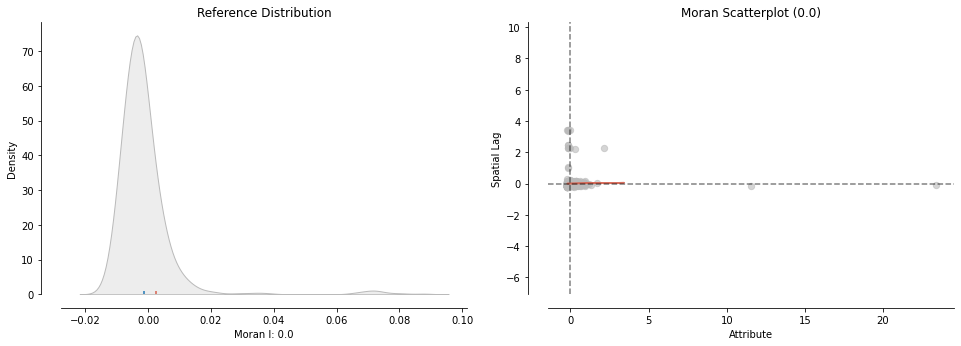

In [7]:
w = libpysal.weights.KNN.from_dataframe(geo_db, k=10)
y = db['Area']
mi = esda.moran.Moran(y, w)
print("Moran's Index (M): {:.10f}; P-Sim: {:.3f} (p<0.05)".format(mi.I, mi.p_sim))

plot_moran(mi, figsize=(16,5))
plt.show()

The _Moran's index_ for global association for the continious feature, _Area_, is 0.002, and the p-value (based on permutations, one tailed) confirms statistical significance ($p<0.05$). Recollect from the baseline OLS model that the data reflects heteroscedasticity and non-normality. For this reason, rather than the p-norm or p-random ([see the `esda.Moran` documentation](https://pysal.org/esda/generated/esda.Moran.html#esda.Moran)), we use the p-sim statistic (i.e., `mi.p_sim`) to confirm the null-hypothesis ($H_0$). Kabacoff (2011) recommends that if the data has outliers, is too small for standard parametric approaches, or is non-normal, "a permutation test provides an excellent alternative" (Kabocoff, 2011, p. 293). 

Finally, insofar as $H_0$ is larger than the $p$<0.05 threshold,  the _Moran's I_ equalling 0.002, for the 10 nearest neighbours ($k$=10), the data (i.e., Gardens and Seapoint combined, $n$=720) has no global spatial association for a sign's Area.

### 2.1.2 Gardens

Moran's I for Global Spatial Association, Gardens: -0.006; and p-sim = 0.307 (p<0.05)


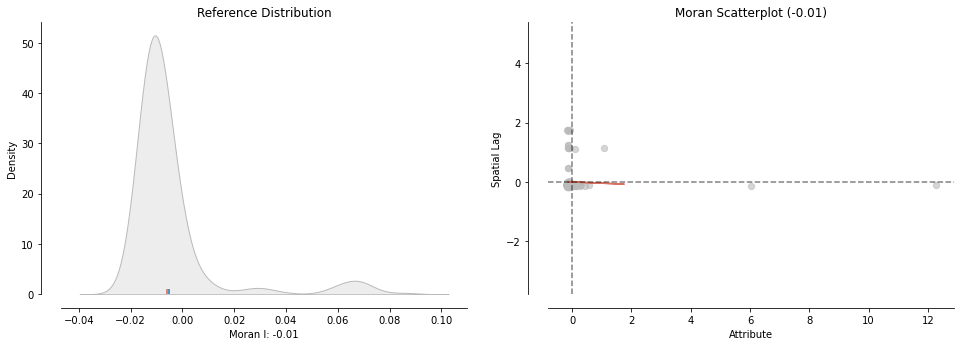

In [8]:
# Create weight
w_gardens = libpysal.weights.KNN.from_dataframe(geoGardens, k=10)

# Create the pysal Moran object
y_gardens = geoGardens['Area']
mi_gardens = esda.moran.Moran(y_gardens, w_gardens)

# Verify Moran's I result 
print("Moran's I for Global Spatial Association, Gardens: {:.3f}; and p-sim = {:.3f} (p<0.05)".format(mi_gardens.I, 
                                                                                                      mi_gardens.p_sim))
plot_moran(mi_gardens, figsize=(16,5))
plt.show()

As regards Gardens, from the _Morans I_ for global association and the _p-sim_ statistic, $H_0$ is not rejected, suggesting no global spatial association for a sign's _Area_.

### 2.1.3 Seapoint

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Moran's I for Global Spatial Association, Seapoint: 0.078; and p-sim = 0.001 (p<0.05)


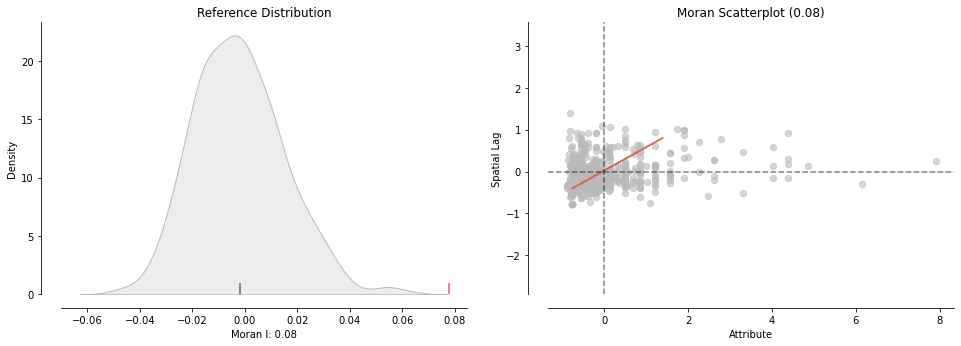

In [9]:
# Create Weight
w_seapoint = libpysal.weights.KNN.from_dataframe(geoSeapoint, k=10)

# Create the pysal Moran object
y_seapoint = geoSeapoint['Area']
mi_seapoint = esda.moran.Moran(y_seapoint, w_seapoint)

# Verify Moran's I result 
print("Moran's I for Global Spatial Association, Seapoint: {:.3f}; and p-sim = {:.3f} (p<0.05)".format(mi_seapoint.I, 
                                                                                                       mi_seapoint.p_sim))
plot_moran(mi_seapoint, figsize=(16,5))
plt.show()

Given the _Morans I_ and _p-sim_ statistic for Seapoint, the $H_0$'s rejected, suggesting that, albeit negligible, a sign's _Area_ is spatially assocated with its nearest neightbours such that it hadn't occured by chance alone.

## 2.2 Local Spatial Association

### 2.2.1 Gardens & Seapoint

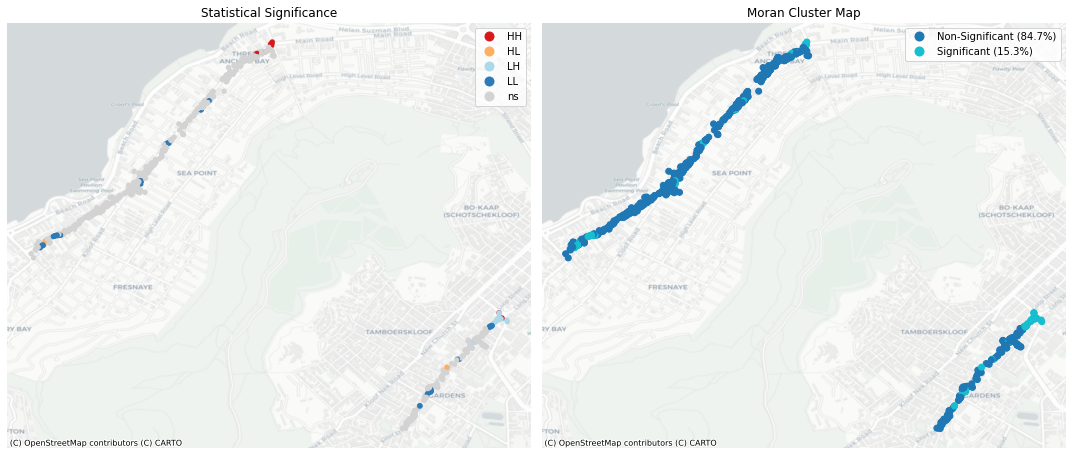

In [10]:
# Create Pysal Local Moran Object for combined data (Seapoint & Gardens)
local_mi = esda.moran.Moran_Local(y, w, transformation='r', permutations = 101, seed=101)
plot_moran_local(local_mi, geo_db)
# Assign Moran_Local stats to DataFrame
add_moran_stats(local_mi, 0.05, geo_db)

The combined Gardens and Seapoint data reflects local spatial dependence, but the number of points that are spatially dependent such that it hadn't occured by chance is a mere 15.3% (of $n$=720)—shown in the Morans Cluster Map on the right. (In either map above, Seapoint is the area in the top left cornerw, while Gardens is in the bottom right corner.) 

For the _Statistical Significance Map_, both Gardens and Seapoint have High-High value observations (HH), or larger than average signs clustering at their entrance points. Accordingly for Gardens, these larger signs neighbour other smaller signs, or low value signs, forming a Low-High (LH) value cluster, also known as a _'doughnut'_. (To be clear, the value considered here is a sign's Area.) Continuing along Gardens we find a cluster of High-Low (HL) observations—i.e., larger signs surrounded by smaller signs, also known as a _'diamond'_. And finally, toward Seapoint's exit a cluster of low value observations (LL) is encountered concomitant of an HL cluster.

### 2.2.2 Gardens

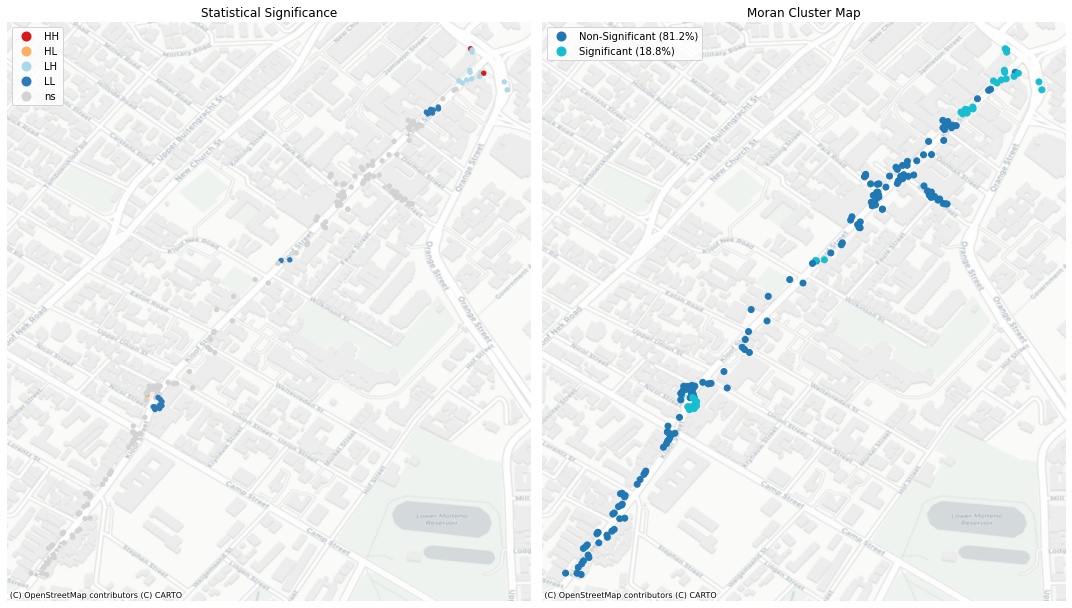

In [11]:
# Create Pysal Local Moran Object for Gardens
local_mi = esda.moran.Moran_Local(y_gardens, w_gardens, transformation='r', permutations = 101, seed=101)
plot_moran_local(local_mi, geoGardens)
# Assign Moran_Local stats to DataFrame
add_moran_stats(local_mi, 0.05, geoGardens)

### 2.2.3 Seapoint

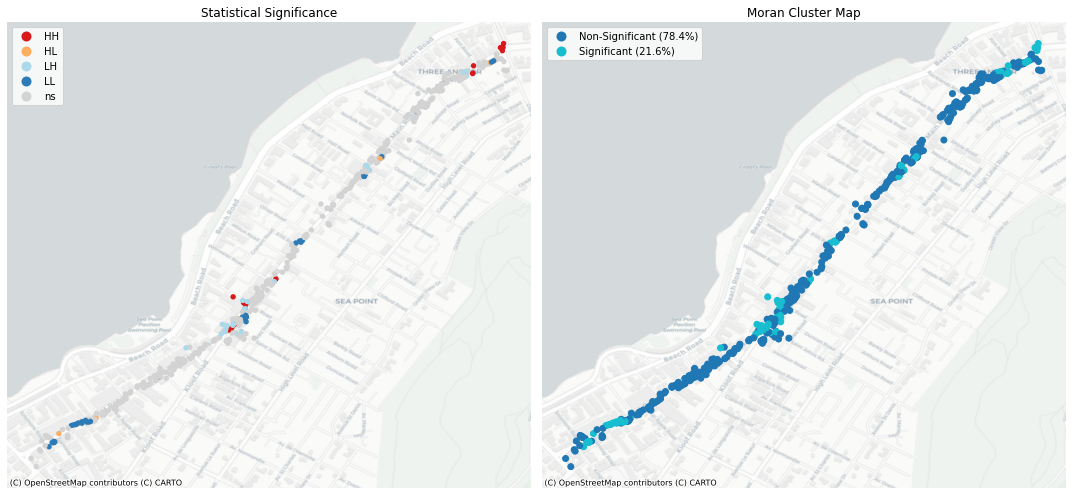

In [12]:
# Create Pysal Local Moran Object for Seapoint
local_mi = esda.moran.Moran_Local(y_seapoint, w_seapoint, transformation='r', permutations = 101, seed=101)
plot_moran_local(local_mi, geoSeapoint)
# Assign Moran_Local stats to DataFrame
add_moran_stats(local_mi, 0.05, geoSeapoint)

Recollect that in contrast to the combined- and Gardens data set (sections 2.2.1 and 2.2.2 resepetively), Seapoint showed both positive global and local spatial association. Noting that it also has a higher percentage of statistically significant signs—their areas which are spatially associated such that it is not by chance alone. Unclear in the combined Gardens and Seapoint local plot, but indeed clearer in the Seapoint plot above, is the HH and LH clusters toward the middle of the stretch. This observation would have been missed had we not checked for local dependence for each suburb. Additional OLS estimations is thus motivated to this end, firstly by deriving baseline models for not only the Gardens and Seapoint data combined (as in section 1 above), but for each suburb; then compare those to their spatially lagged counterparts. However, we can expect that compared to Seapoint, the Gardens, and combined data set's spatial lag will be null or minor. 

# 3. Gardens and Seapoint Base-Line Models

## 3.1 Gardens

In [13]:
#Fit Baseline Model
explanatory_vars = ['Height', 'Width']
m_gardens = spreg.OLS(np.log(geoGardens[['Area']].values), geoGardens[explanatory_vars].values, 
               name_y = 'Area', name_x = explanatory_vars)

print(m_gardens.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        Area                Number of Observations:         192
Mean dependent var  :      0.2735                Number of Variables   :           3
S.D. dependent var  :      1.1851                Degrees of Freedom    :         189
R-squared           :      0.6835
Adjusted R-squared  :      0.6802
Sum squared residual:      84.888                F-statistic           :    204.1097
Sigma-square        :       0.449                Prob(F-statistic)     :   6.039e-48
S.E. of regression  :       0.670                Log likelihood        :    -194.084
Sigma-square ML     :       0.442                Akaike info criterion :     394.168
S.E of regression ML:      0.6649                Schwarz criterion     :     403.941

-----------------------------------------------------------------------------

## 3.2 Seapoint

In [14]:
#Fit Baseline Model
explanatory_vars = ['Height', 'Width']
m_seapoint = spreg.OLS(np.log(geoSeapoint[['Area']].values), geoSeapoint[explanatory_vars].values, 
               name_y = 'Area', name_x = explanatory_vars)

print(m_seapoint.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        Area                Number of Observations:         528
Mean dependent var  :      0.5020                Number of Variables   :           3
S.D. dependent var  :      0.9706                Degrees of Freedom    :         525
R-squared           :      0.7727
Adjusted R-squared  :      0.7718
Sum squared residual:     112.848                F-statistic           :    892.3541
Sigma-square        :       0.215                Prob(F-statistic)     :  1.283e-169
S.E. of regression  :       0.464                Log likelihood        :    -341.834
Sigma-square ML     :       0.214                Akaike info criterion :     689.667
S.E of regression ML:      0.4623                Schwarz criterion     :     702.474

-----------------------------------------------------------------------------

While a sign's height in Seapoint has a greater influence on its Area than in Gardens, a signs width in Gardens has a greater influence on its Area than in Seapoint. 

Both models suggest heteroscedasticity by way of the Breusch-Pagan Test, $p$<0.05 (for discritive statistics, see part 1). 

## 3.3 Compare Base Models

In [53]:
model_list = [m1_log, m_gardens, m_seapoint]
name_list = ['Global Model', 'Gardens', 'Seapoint']
compare_models(model_list, name_list)

                                      Global Model     Gardens     Seapoint
CONSTANT                                 -0.713702   -0.745486    -0.990302
HEIGHT                                    0.337005    0.216289     0.660912
WIDTH                                     0.301929    0.307020     0.313372
MULTICOLLINEARITY                         3.185064    2.939475     3.995777
NORMALITY (Jarque-Bera)                3085.681394  104.731580  1014.783395
HETEROSKEDASTICITY (Breusch-Pagan)     2378.781453   72.297391   542.789379
HETEROSKEDASTICITY (Koenker-Bassett)    420.251392   30.167649   141.252015
R-SQAURED                                 0.688296    0.683533     0.772699
ADJUSTED R-SQAURED                        0.687427    0.680185     0.771833
AIC                                    1260.225237  394.168314   689.667103


# 4. Spatially Lagged Endogenous Regression

## 4.1 Global

In [16]:
model_variables = explanatory_vars + ['Area']
data = geo_db.dropna(subset=model_variables).copy()
weight = weights.KNN.from_dataframe(data, 
                                    k=10) # nearest neighbours
weight.transform = 'R' # row standardised

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [17]:
m1_log_spatial_lag = spreg.GM_Lag(np.log(data[['Area']].values), 
                                   data[explanatory_vars].values, 
                                   name_y = 'ln(Area)', 
                                   name_x = explanatory_vars,
                                  w=weight)

print(m1_log_spatial_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    ln(Area)                Number of Observations:         720
Mean dependent var  :      0.4411                Number of Variables   :           4
S.D. dependent var  :      1.0362                Degrees of Freedom    :         716
Pseudo R-squared    :      0.7024
Spatial Pseudo R-squared:  0.6928

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.7861604       0.0405248     -19.3994709       0.0000000
              Height       0.3342001       0.0186772      17.8934444       0.0000000
               Width       0.2972352       0.0092569      3

## 4.2 Local

### 4.2.1 Gardens

In [18]:
data = geoGardens.dropna(subset=model_variables).copy()
weight = weights.KNN.from_dataframe(data, 
                                    k=10) # nearest neighbours
weight.transform = 'R' # row standardised

m_gardens_spatial_lag = spreg.GM_Lag(np.log(geoGardens[['Area']].values), 
                                   geoGardens[explanatory_vars].values, 
                                   name_y = 'ln(Area)', 
                                   name_x = explanatory_vars,
                                  w=weight)

print(m_gardens_spatial_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    ln(Area)                Number of Observations:         192
Mean dependent var  :      0.2735                Number of Variables   :           4
S.D. dependent var  :      1.1851                Degrees of Freedom    :         188
Pseudo R-squared    :      0.6915
Spatial Pseudo R-squared:  0.6861

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.7981767       0.0789389     -10.1113280       0.0000000
              Height       0.2138226       0.0274708       7.7836359       0.0000000
               Width       0.3077320       0.0213632      1

The statistical insignificance of the spatial lag estimate of Area corroborates the findings in 2.1.2, that there's no spatial association for a sign's Area in Gardens. Further, a unit increase in Width corresponds to a 0.31 unit increase in the Area. Likewise, a unit increase in Height corresponds to a 0.21 unit increase in the Area.

### 4.2.2 Seapoint

In [19]:
data = geoSeapoint.dropna(subset=model_variables).copy()
weight = weights.KNN.from_dataframe(data, 
                                    k=10) # nearest neighbours
weight.transform = 'R' # row standardised

m_seapoint_spatial_lag = spreg.GM_Lag(np.log(geoSeapoint[['Area']].values), 
                                   geoSeapoint[explanatory_vars].values, 
                                   name_y = 'ln(Area)', 
                                   name_x = explanatory_vars,
                                  w=weight)

print(m_seapoint_spatial_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    ln(Area)                Number of Observations:         528
Mean dependent var  :      0.5020                Number of Variables   :           4
S.D. dependent var  :      0.9706                Degrees of Freedom    :         524
Pseudo R-squared    :      0.7814
Spatial Pseudo R-squared:  0.7766

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -1.0415684       0.0439717     -23.6872282       0.0000000
              Height       0.6509662       0.0282359      23.0545403       0.0000000
               Width       0.3083895       0.0087430      3

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


The statistical significane of the spatial lag of Area corroborates the findings in 2.1.3, that a sign's Area in Seapoint is spatially associated with its nearest neightbours such that it hadn't occured by chance alone. Hence a likely interdependence exist where an establishment's signage area takes into account neighbouring signs's area.

# 5. Spatially Lagged Exogenous Regressors

In this section we examine the effect of surrounding variables on a sign's Area. That is, how surrounding illuminated signs affect a sign's Area. Granted that the first law of geography puts it that _"everything is (spatialy) related to everything else, but near things are more related than distant things"_ (Tobler 1970), (and therefore spatially auto-correlated,) the statistical assumption that (prediction errors are independent and therefore) observations are independent of each other is not met. However, in his [tutorial](https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html), Henrikki Tenkanen renew this view, maintaining that the spatial lag of the explanotory variable (of the surrounding signs), which we anticipate affecting a sign's area, is spatially transformed. Hence preserving the dependency assumption above. The mathematical expression for spatially lagging one the explanatory variables is thus:

$$\ln(A_i) = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i$$

$\ln(A_i)$ is the dependent variable (logarithmic Area), $X'_i$ is a subset of $X_i$, although it could encompass all of the explanatory variables, and $w_{ij}$ is the $ij$-th cell of a spatial weights matrix $W$.

In [26]:
from pysal.lib import weights
# Create weights
wght = weights.KNN.from_dataframe(geo_db, k=10)
# Assign spatial lag based on whether a sign is of type illuminated.
lagged_illum = geo_db.assign(w_illum=weights.spatial_lag.lag_spatial(wght, geo_db['Illuminated'].values))
lagged_illum.head()

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


,Sign,Illuminated,Area,Height,Width,Suburb,geometry,Is,pvalue,group,w_illum
0,flatsgn,1,300.00,20.0,15.0,Gardens,POINT (18.41352 -33.92733),-2.066805,0.333333,Non-significant,5.0
1,flatsgn,1,1.00,1.0,1.0,Gardens,POINT (18.41338 -33.92744),-0.566598,0.009804,LH-cold outlier,5.0
2,flatsgn,1,150.00,15.0,10.0,Gardens,POINT (18.41314 -33.92760),-1.605580,0.058824,Non-significant,3.0
3,flatsgn,1,1.20,0.3,4.0,Gardens,POINT (18.41255 -33.92815),0.016173,0.205882,Non-significant,5.0
4,flatsgn,0,0.75,0.5,1.5,Gardens,POINT (18.41261 -33.92816),0.019347,0.235294,Non-significant,6.0


In [36]:
extended_vars = explanatory_vars + ['Illuminated', 'w_illum']
m2 = spreg.OLS(np.log(lagged_illum[['Area']].values), lagged_illum[extended_vars].values, 
               name_y = 'log_area', name_x = extended_vars)
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    log_area                Number of Observations:         192
Mean dependent var  :      0.2735                Number of Variables   :           5
S.D. dependent var  :      1.1851                Degrees of Freedom    :         187
R-squared           :      0.6998
Adjusted R-squared  :      0.6934
Sum squared residual:      80.518                F-statistic           :    108.9925
Sigma-square        :       0.431                Prob(F-statistic)     :   9.055e-48
S.E. of regression  :       0.656                Log likelihood        :    -189.010
Sigma-square ML     :       0.419                Akaike info criterion :     388.021
S.E of regression ML:      0.6476                Schwarz criterion     :     404.308

-----------------------------------------------------------------------------

That a sign is of type illuminated is associated with a 1.1 unit increase in Area. Albeit statistically insignificant, the number of neighbouring illuminated signs has no significant effect on a sign's Area. 

## 5.1 Gardens

In [32]:
wght = weights.KNN.from_dataframe(geoGardens, k=10)
# Assign spatial lag based on whether a sign is of type illuminated.
lagged_illum = geoGardens.assign(w_illum=weights.spatial_lag.lag_spatial(wght, geoGardens['Illuminated'].values))
lagged_illum.head()

,Sign,Illuminated,Area,Height,Width,Suburb,geometry,Is,pvalue,group,w_illum
0,flatsgn,1,300.00,20.0,15.0,Gardens,POINT (18.41352 -33.92733),-1.297844,0.441176,Non-significant,5.0
1,flatsgn,1,1.00,1.0,1.0,Gardens,POINT (18.41338 -33.92744),-0.255745,0.009804,LH-cold outlier,5.0
2,flatsgn,1,150.00,15.0,10.0,Gardens,POINT (18.41314 -33.92760),-0.798886,0.088235,Non-significant,3.0
3,flatsgn,1,1.20,0.3,4.0,Gardens,POINT (18.41255 -33.92815),0.016101,0.313725,Non-significant,5.0
4,flatsgn,0,0.75,0.5,1.5,Gardens,POINT (18.41261 -33.92816),0.017978,0.343137,Non-significant,6.0


In [37]:
#extended_vars = explanatory_vars + ['Illuminated', 'w_illum']
m_gardens_lag_illum = spreg.OLS(np.log(lagged_illum[['Area']].values), lagged_illum[extended_vars].values, 
               name_y = 'log_area', name_x = extended_vars)
print(m_gardens_lag_illum.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        Area                Number of Observations:         192
Mean dependent var  :      0.2735                Number of Variables   :           5
S.D. dependent var  :      1.1851                Degrees of Freedom    :         187
R-squared           :      0.6998
Adjusted R-squared  :      0.6934
Sum squared residual:      80.518                F-statistic           :    108.9925
Sigma-square        :       0.431                Prob(F-statistic)     :   9.055e-48
S.E. of regression  :       0.656                Log likelihood        :    -189.010
Sigma-square ML     :       0.419                Akaike info criterion :     388.021
S.E of regression ML:      0.6476                Schwarz criterion     :     404.308

-----------------------------------------------------------------------------

## 5.2 Seapoint

In [38]:
wght = weights.KNN.from_dataframe(geoSeapoint, k=10)
# Assign spatial lag based on whether a sign is of type illuminated.
lagged_illum = geoSeapoint.assign(w_illum=weights.spatial_lag.lag_spatial(wght, geoSeapoint['Illuminated'].values))
lagged_illum.head()

/Users/ad/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,Sign,Illuminated,Area,Height,Width,Suburb,geometry,Is,pvalue,group,w_illum
192,flatsgn,1,8.0,1.0,8.0,Seapoint,POINT (18.39747 -33.90801),1.904776,0.019608,HH-hotspot,9.0
193,flatsgn,1,10.5,1.5,7.0,Seapoint,POINT (18.39735 -33.90815),2.193412,0.039216,HH-hotspot,9.0
194,flatsgn,1,6.0,1.5,4.0,Seapoint,POINT (18.39741 -33.90813),1.138493,0.029412,HH-hotspot,9.0
195,flatsgn,1,7.5,1.5,5.0,Seapoint,POINT (18.39745 -33.90815),1.759652,0.019608,HH-hotspot,9.0
196,flatsgn,1,8.0,1.0,8.0,Seapoint,POINT (18.39742 -33.90826),1.904776,0.019608,HH-hotspot,9.0


In [40]:
#extended_vars = explanatory_vars + ['Illuminated', 'w_illum']
m_seapoint_lag_illum = spreg.OLS(np.log(lagged_illum[['Area']].values), lagged_illum[extended_vars].values, 
               name_y = 'log_area', name_x = extended_vars)
print(m_seapoint_lag_illum.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    log_area                Number of Observations:         528
Mean dependent var  :      0.5020                Number of Variables   :           5
S.D. dependent var  :      0.9706                Degrees of Freedom    :         523
R-squared           :      0.7815
Adjusted R-squared  :      0.7798
Sum squared residual:     108.489                F-statistic           :    467.5910
Sigma-square        :       0.207                Prob(F-statistic)     :   3.89e-171
S.E. of regression  :       0.455                Log likelihood        :    -331.433
Sigma-square ML     :       0.205                Akaike info criterion :     672.866
S.E of regression ML:      0.4533                Schwarz criterion     :     694.212

-----------------------------------------------------------------------------

The number of neighbouring illuminated signs has a negligible effect on a sign's Area for Seapoint as it does Gardens, noting that the former's w_illum is statistically insignificant.

# Summary
Moran's I was used to measure spatial auto-correlation. The total data set—seapoint and gardens combined—reflect no spatial auto-correlation; neither for the Gardens data set. However, the area of business sings are spatially auto-correlated. In contrast to Gardens, an interdependence exist where an establishment's signage area in Seapoint takes into account neighbouring signs' area. The Breusch-Pagan test for either data set suggest heteroscedasticity. Finally, the number of neighbouring illuminated signs has a negligible effect on a sign's Area for Seapoint as it does Gardens, noting that the former's w_illum is statistically insignificant.

# References

Anselin, L. (1995). Local Indicators of Spatial Association—LISA. Geographical Analysis, 27(2), 93–115. https://doi.org/10.1111/j.1538-4632.1995.tb00338.x

Haslwanter, T. (2016). An Introduction to Statistics with Python. http://www.springer.com/series/3022

Hoffmann, J. P. (2022). Linear Regression Models - Applications in R.


